## Packages

In [1]:
ask_workers = 24

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=ask_workers,dashboard_address=':8686')
c = Client(cluster)
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8686/status,
Dashboard: http://127.0.0.1:8686/status,Workers: 24
Total threads: 24,Total memory: 187.53 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42167,Workers: 24
Dashboard: http://127.0.0.1:8686/status,Total threads: 24
Started: Just now,Total memory: 187.53 GiB
Comm: tcp://127.0.0.1:37059,Total threads: 1
Dashboard: http://127.0.0.1:43331/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:40239,


In [3]:
import os
import numpy as np
import xarray as xr
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pylab as plt
import scipy.fftpack as fp
from scipy import signal 
from dask import delayed,compute
from scipy import spatial
from scipy.spatial.distance import cdist
xr.__version__

'0.16.2'

In [3]:
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans

In [4]:
import sys
dirTools = '/bettik/leguilfl/git/DAdiags/'
sys.path.insert(0,dirTools)
import Wavenum_freq_spec_func as wfs
import PowerSpec as ps

## Parameters

In [5]:
dir_data = '/bettik/leguilfl/Studies/MASSH_CCS/data/32_39_233_236'
pattern = 'ssh_raw'

t0 = np.datetime64('2012-01-01')
t1 = np.datetime64('2012-12-31T23')

## Load SSH data

In [6]:
ds = xr.open_mfdataset(os.path.join(dir_data,pattern+'*.nc'))
ds = ds.sel({'time':slice(t0,t1)})
ds

<xarray.Dataset>
Dimensions:  (time: 7399, lon: 29, lat: 73)
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 ... 2012-11-04T06:00:00
  * lon      (lon) float64 233.2 233.3 233.4 233.5 ... 235.7 235.8 235.9 236.0
  * lat      (lat) float64 32.0 32.1 32.2 32.3 32.4 ... 38.8 38.9 39.0 39.1 39.2
Data variables:
    ssh      (time, lat, lon) float64 dask.array<chunksize=(24, 73, 29), meta=np.ndarray>

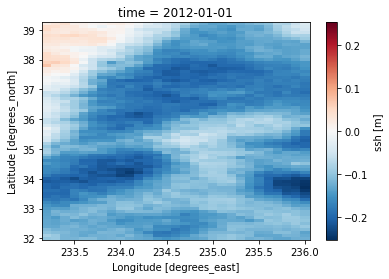

In [7]:
ds.ssh[0].plot()

In [8]:
lon = ds.lon.values
lat = ds.lat.values
times = ds.time.values
nt = times.size
ny = lat.size
nx = lon.size

## BM & HF motions

In [9]:
# Coriolis period
f = 2*2*np.pi/86164*np.sin(np.mean(np.deg2rad(lat)))
T = 2*np.pi/f
print(T//3600)

20.0


In [10]:
def gaspari_cohn(r,c):
    """
    NAME 
        bfn_gaspari_cohn

    DESCRIPTION 
        Gaspari-Cohn function. Inspired from E.Cosmes.
        
        Args: 
            r : array of value whose the Gaspari-Cohn function will be applied
            c : Distance above which the return values are zeros


        Returns:  smoothed values 
            
    """ 
    if type(r) is float or type(r) is int:
        ra = np.array([r])
    else:
        ra = r
    if c<=0:
        return np.zeros_like(ra)
    else:
        ra = 2*np.abs(ra)/c
        gp = np.zeros_like(ra)
        i= np.where(ra<=1.)[0]
        gp[i]=-0.25*ra[i]**5+0.5*ra[i]**4+0.625*ra[i]**3-5./3.*ra[i]**2+1.
        i =np.where((ra>1.)*(ra<=2.))[0]
        gp[i] = 1./12.*ra[i]**5-0.5*ra[i]**4+0.625*ra[i]**3+5./3.*ra[i]**2-5.*ra[i]+4.-2./3./ra[i]
        if type(r) is float:
            gp = gp[0]
    return gp


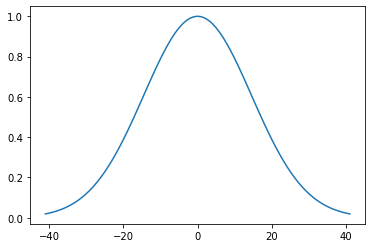

In [11]:
dt = 3600
window_len = int(2*T//dt)
time_window = np.arange(-window_len,window_len+1)
exp_window = np.exp(-np.square(time_window/(T/dt)))

plt.plot(time_window,exp_window)

ntw = time_window.size

In [12]:
weight = xr.DataArray(exp_window, dims=['window'])
ssh = ds.ssh.chunk({'time':ntw,'lon':nx,'lat':ny})[:nt-nt%ntw]
ssh_bm = ssh.rolling(time=ntw, center=True).construct('window').dot(weight)/weight.sum()
ssh_bm

<xarray.DataArray (time: 7387, lat: 73, lon: 29)>
dask.array<truediv, shape=(7387, 73, 29), dtype=float64, chunksize=(124, 73, 29), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 ... 2012-11-03T18:00:00
  * lon      (lon) float64 233.2 233.3 233.4 233.5 ... 235.7 235.8 235.9 236.0
  * lat      (lat) float64 32.0 32.1 32.2 32.3 32.4 ... 38.8 38.9 39.0 39.1 39.2

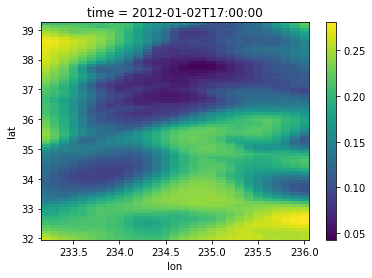

In [13]:
ssh_bm[window_len].plot()

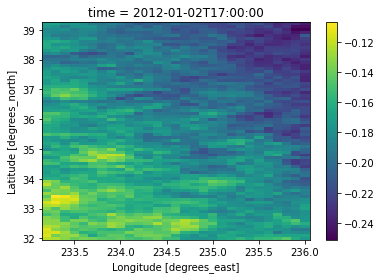

In [14]:
ssh_hf = ssh - ssh_bm
ssh_hf[window_len].plot()

In [15]:
nt,ny,nx = ssh_hf.shape

## Remove barotropic tides

In [16]:
# Grid resolution

def lonlat2dxdy(lon,lat):
    dlon = np.gradient(lon)
    dlat = np.gradient(lat)
    dx = np.sqrt((dlon[1]*111000*np.cos(np.deg2rad(lat)))**2
                 + (dlat[1]*111000)**2)
    dy = np.sqrt((dlon[0]*111000*np.cos(np.deg2rad(lat)))**2
                 + (dlat[0]*111000)**2)
    dx[0,:] = dx[1,:]
    dx[-1,: ]= dx[-2,:] 
    dx[:,0] = dx[:,1]
    dx[:,-1] = dx[:,-2]
    dy[0,:] = dy[1,:]
    dy[-1,:] = dy[-2,:] 
    dy[:,0] = dy[:,1]
    dy[:,-1] = dy[:,-2]
    return dx,dy


lon2d,lat2d = np.meshgrid(lon,lat)
dx,dy = lonlat2dxdy(lon2d,lat2d)
dx0 = dx.mean()
dy0 = dy.mean()

kx = np.fft.fftfreq(3*nx,dx0*1e-3) # km
ky = np.fft.fftfreq(3*ny,dy0*1e-3) # km
k, l = np.meshgrid(kx,ky)
wavnum2D = np.sqrt(k**2 + l**2)

## Spatial window

winy = np.ones(3*ny)
winy[:ny] = gaspari_cohn(np.arange(0,ny,1),ny)[::-1]
winy[2*ny:] = gaspari_cohn(np.arange(0,ny),ny)

winx = np.ones(3*nx)
winx[:nx] = gaspari_cohn(np.arange(0,nx,1),nx)[::-1]
winx[2*nx:] = gaspari_cohn(np.arange(0,nx),nx)

window = winy[:,np.newaxis] * winx[np.newaxis,:]

kernel = Gaussian2DKernel(x_stddev=20)

In [22]:


def extend(ssh):
    ssh_extended = np.empty((3*ny,3*nx))
    ssh_extended[ny:2*ny,nx:2*nx] = +ssh
    ssh_extended[0:ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[2*ny:3*ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[:,0:nx] = ssh_extended[:,nx:2*nx][:,::-1]
    ssh_extended[:,2*nx:3*nx] = ssh_extended[:,nx:2*nx][:,::-1]
    return ssh_extended

def highpass(_lambda):
    _highpass = np.zeros((3*ny,3*nx))
    for i in range(3*ny):
        for j in range(3*nx):
            if wavnum2D[i,j]>1/_lambda:
                _highpass[i,j] = 1
    return _highpass

def apply_filter(ssh_freq,H):
    ssh_freq_filtered = H * ssh_freq
    ssh_filtered = np.real(fp.ifft2(ssh_freq_filtered))
    return ssh_filtered

lambda_bar = 200

highpass_IT = highpass(lambda_bar)

In [1]:
frame_per_files = 24
import gc
def create_dataset(t0,path,plot=False):
    _nt = min(frame_per_files,nt-t0)
    shapeout = (_nt,lat.size,lon.size)
    _ssh = ssh.isel(time=slice(t0,t0+_nt))
    _ssh_bm = ssh_bm.isel(time=slice(t0,t0+_nt))
    _ssh_hf = ssh_hf.isel(time=slice(t0,t0+_nt))
    _ssh_bar = xr.DataArray(np.empty(shapeout), dims=['time','lat','lon'])
    _ssh_igw = xr.DataArray(np.empty(shapeout), dims=['time','lat','lon'])
    for i in range(_nt):
        ssh0 = ssh_hf[t0+i].values
        mask = np.isnan(ssh0)
        if plot and i==0:
            plt.figure()
            plt.pcolormesh(ssh0)
            plt.show()
            
        # Extend
        ssh_extended = extend(ssh0)
        if plot and i==0:
            plt.figure()
            plt.pcolormesh(ssh_extended)
            plt.show()
        
        # Remove nans
        ssh_extended_noNans = interpolate_replace_nans(ssh_extended, kernel)
        if plot and i==0:
            plt.figure()
            plt.pcolormesh(ssh_extended_noNans)
            plt.show()
            
        # Windowing
        ssh_win = ssh_extended_noNans * window
        if plot and i==0:
            plt.figure()
            plt.pcolormesh(ssh_win)
            plt.show()
            
        # FFT
        ssh_freq = fp.fft2(ssh_win)
        
        # Filter
        ssh_igw = apply_filter(ssh_freq, highpass_IT)[ny:2*ny,nx:2*nx]
        
        # Mask
        ssh_igw[mask] = np.nan
        if plot and i==0:
            plt.figure()
            plt.pcolormesh(ssh_igw,cmap='RdBu_r')
            plt.colorbar()
            plt.show()
            
        # Fill array
        _ssh_bar[i] = ssh0 - ssh_igw
        _ssh_igw[i] = ssh_igw
        
        
    dsout = xr.Dataset({'ssh_full':(('time','lat','lon'),_ssh.data),
                        'ssh_corr':(('time','lat','lon'),_ssh.data-_ssh_bar.data),
                        'ssh_bm':(('time','lat','lon'),_ssh_bm.data),
                        'ssh_bar':(('time','lat','lon'),_ssh_bar.data.data),
                        'ssh_igw':(('time','lat','lon'),_ssh_igw.data)
                       },
                       coords={'time':('time',times[t0:t0+_nt]),'lat':('lat',lat),'lon':('lon',lon)}
                      )
    dsout.to_netcdf(path)
    
    dsout.close()
    del dsout
    del _ssh,_ssh_bm,_ssh_igw,_ssh_hf,ssh_freq,ssh_igw,ssh0,_ssh_bar,mask
    gc.collect()
    
    return path


In [2]:
time_save = np.arange(window_len,nt-window_len,frame_per_files)

def create_filepath(date, prefix='ssh_filt', root_path=dir_data):
    filepath = f'{root_path}/{prefix}_{date}.nc'
    return filepath

dates = [pd.to_datetime(str(ds.time.data[t])).strftime("%Y-%m-%d") for t in time_save]
paths = [create_filepath(date) for date in dates]

NameError: name 'np' is not defined

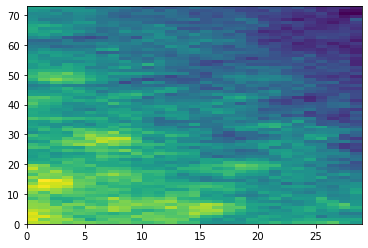

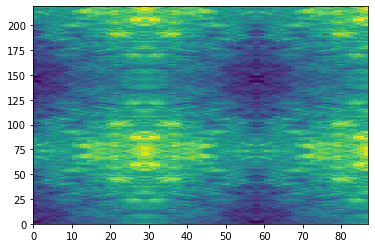

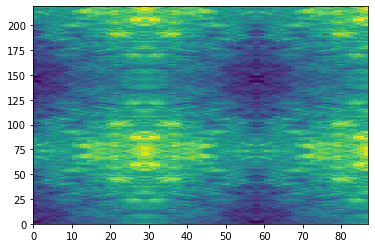

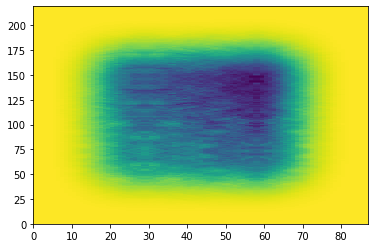

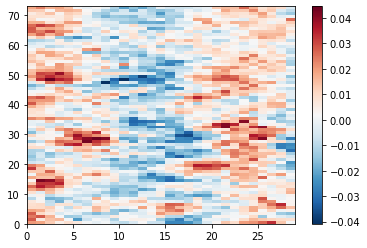

'/bettik/leguilfl/Studies/MASSH_CCS/data/32_39_233_236/ssh_filt_2012-01-02.nc'

In [25]:
create_dataset(time_save[0],paths[0],plot=True)

In [26]:
delayed_results = []
for t0,path in zip(time_save,paths):
    if os.path.exists(path):
        continue
    res = delayed(create_dataset)(t0, path)
    delayed_results.append(res)
results = compute(*delayed_results, scheduler="processes")